In [2]:
def read_binary_with_structure(file_path, x_range=0, y_range=0):

    with open(file_path, "rb") as f:
        # === 1. 時間を読み取る ===
        ttime_0 = np.fromfile(f, dtype=np.float32, count=2)
        ttime=ttime_0[1]

        # === 2. nx, ny を読み取る ===
        nx, ny = np.fromfile(f, dtype=np.int32, count=2)
        # print("step_time:",ttime,"[s]")
        # print("nx",nx,"ny",ny)

        # 範囲インデックス
        if  x_range==0 and y_range==0:
          x_min, x_max = [0,nx]
          y_min, y_max = [0,ny]
        else:    
          x_min, x_max = x_range
          y_min, y_max = y_range
        # print("x_min",x_min,"x_max",x_max,"y_min",y_min,"y_max",y_max)
        # print("x_range",range(x_min, x_max))
        # === 3. x4, y4 の読み取り ===
        x4 = np.fromfile(f, dtype=np.float32, count=nx+1)*1e-2
        y4 = np.fromfile(f, dtype=np.float32, count=ny+1)[1:]*1e-2
        u4 = np.fromfile(f, dtype=np.float32, count=(nx+1)*(ny+1)).reshape((nx+1,ny+1), order='F')[:,1:]*1e-2
        v4 = np.fromfile(f, dtype=np.float32, count=(nx+1)*(ny+1)).reshape((nx+1,ny+1), order='F')[:,1:]*1e-2

        # print("x4_len",len(x4))
        # print("y4_len",len(y4))
        # print("x4",x4[0:3])
        # print("y4",y4[0:3])

        # === 4. 2次元配列 (rh4, p4, te4, ti4, zi4) の読み取り ===
        def read_2d_array():
            return np.fromfile(f, dtype=np.float32, count=(nx) * (ny)).reshape((nx,ny), order='F')[:,1:]
        rh4 = read_2d_array()
        p4 = read_2d_array()*1e-1
        te4 = read_2d_array()
        ti4 = read_2d_array()        
        zi4 = read_2d_array()
        # print("p4_shape",p4.shape)


        # === 5. mtldb (整数型2次元配列) の読み取り ===
        mtldb = np.fromfile(f, dtype=np.int32, count=(nx) * (ny)).reshape((nx,ny), order='F')[:,1:]

        # === 6. その他 (aaomtl, wlaserwrite, flsr) の読み取り ===
        aaomtl = np.fromfile(f, dtype=np.float32, count=3)
        wlaserwrite = np.fromfile(f, dtype=np.float32, count=2)
        flsr = np.fromfile(f, dtype=np.float32, count=2)
        # print("aaomtl",aaomtl)
        # print("wlaserwrite",wlaserwrite)
        # print("flsr",flsr)
        
        nxr1 = np.fromfile(f, dtype=np.int32,count=1)[0]
        nxr2 = np.fromfile(f, dtype=np.int32,count=1)[0]
        nxr3 = np.fromfile(f, dtype=np.int32,count=1)[0]
        nxr4 = np.fromfile(f, dtype=np.int32,count=1)[0]
        nxr5 = np.fromfile(f, dtype=np.int32,count=1)[0]
        jjfine = np.fromfile(f, dtype=np.int32,count=1)[0]
        rtthick = np.fromfile(f, dtype=np.float32,count=1)[0]*1e-2
        xleft = np.fromfile(f, dtype=np.float32,count=1)[0]*1e-2
        xright = np.fromfile(f, dtype=np.float32,count=1)[0]*1e-2
        finemesh = np.fromfile(f, dtype=np.float32,count=1)[0]*1e-2
        y_out = np.fromfile(f, dtype=np.float32,count=1)[0]*1e-2
        # rhsp14 = read_2d_array()
        # rhsp24 = read_2d_array()
        # rhsp34 = read_2d_array()
      #   print(f"nxr1: {nxr1}, nxr2: {nxr2}, nxr3: {nxr3}, nxr4: {nxr4}, nxr5: {nxr5}, "
      # f"rtthick: {rtthick}, jjfine: {jjfine}, xleft: {xleft}, xright: {xright}, "
      # f"finemesh: {finemesh}, y_out: {y_out}")
      #   print("rhsp14",rhsp14)
        

        xc = np.zeros((nx, ny-1), dtype=np.float32)
        yc = np.zeros((nx, ny-1), dtype=np.float32)
        uc = np.zeros((nx, ny-1), dtype=np.float32)
        vc = np.zeros((nx, ny-1), dtype=np.float32)
        ent = np.zeros((nx, ny-1), dtype=np.float32)
        one = np.ones((nx, ny-1), dtype=np.float32)

        for j in range(0, ny-1):
          for i in range(0, nx):
            xc[i,j]=(x4[i]+x4[i+1])*0.5
            yc[i,j]=(y4[j]+y4[j+1])*0.5
            uc[i,j]=(u4[i,j]+u4[i+1,j]+u4[i,j+1]+u4[i+1,j+1])*0.25
            vc[i,j]=(v4[i,j]+v4[i+1,j]+v4[i,j+1]+v4[i+1,j+1])*0.25
            if mtldb[i,j] == 1 :
              ent[i,j]=rh4[i,j]/1.6726e-24*zi4[i,j]/aaomtl[0]
            if mtldb[i,j] == 2 :
              ent[i,j]=rh4[i,j]/1.6726e-24*zi4[i,j]/aaomtl[1]
            if mtldb[i,j] == 3 :
              ent[i,j]=rh4[i,j]/1.6726e-24*zi4[i,j]/aaomtl[2]
        # print("xc_shape",xc.shape)
        # print("yc_shape",yc.shape)
        # print("xc",xc[0:3,0:3])
        # print("yc",yc[0:3,0:3])

        # 指定範囲を抽出
        xc = xc[x_min:x_max+1,y_min:y_max+1]
        yc = yc[x_min:x_max+1,y_min:y_max+1]
        uc = uc[x_min:x_max+1,y_min:y_max+1]
        vc = vc[x_min:x_max+1,y_min:y_max+1]
        ent = ent[x_min:x_max+1,y_min:y_max+1]
        rh4 = rh4[x_min:x_max+1, y_min:y_max+1]
        p4 = p4[x_min:x_max+1, y_min:y_max+1]
        te4 = te4[x_min:x_max+1, y_min:y_max+1]
        ti4 = ti4[x_min:x_max+1, y_min:y_max+1]
        zi4 = zi4[x_min:x_max+1, y_min:y_max+1]
        mtldb = mtldb[x_min:x_max+1, y_min:y_max+1]
        one = one[x_min:x_max+1, y_min:y_max+1]
        # rh14 = rh4[x_min:x_max+1, y_min:y_max+1]
        # rh24 = rh4[x_min:x_max+1, y_min:y_max+1]
        # rh34 = rh4[x_min:x_max+1, y_min:y_max+1]

        # print("xc_shape",xc.shape)
        # print("yc_shape",yc.shape)

    # データを辞書形式で返す
    return {
        "time": ttime,
        "nx": nx,
        "ny": ny,
        "x": xc,
        "y": yc,
        "u": uc,
        "v": vc,
        "rho": rh4,
        "en": ent,
        "P": p4,
        "te": te4,
        "ti": ti4,
        "zi": zi4,
        "mtl": mtldb,
        "Target_mol":aaomtl[1],
        "Projectile_mol":aaomtl[2],
        "ambience_mol": aaomtl[0],
        "wlaserwrite": wlaserwrite,
        "flsr": flsr,
        "one": one,
        "nxr1":nxr1,
        "nxr2":nxr2,
        "nxr3":nxr3,
        "nxr4":nxr4,
        "nxr5":nxr5,
        "jjfine":jjfine,
        "rtthick":rtthick,
        "xleft":xleft,
        "xright":xright,
        "finemesh":finemesh,
        "y_out":y_out,
        # "rhosp1": rhsp14,
        # "rhosp2": rhsp24,
        # "rhosp1": rhsp34,
        
    }
#Output units
# x, y : 座標(m)
# u, v : 流速 (m/s)
# rho : 密度 (g/cc)
# en : 電子数密度(個/cc)
# P : 圧力 (Pa)
# te : 電子温度 (eV)
# ti : イオン温度(eV)
# zi : 電離度
# mtl : 物質追跡



#################################
#### P4P_trace_laser.py ####
#################################

d_name :  B20      file_number : 20
target_density : 1.67e+01 [g/cc]
projectile_density : 1.67e+01 [g/cc]
ambience_initial_ionization_degree: 0.025740515
Target_initial_ionization_degree: 1.2348504
projectile_initial_ionization_degree: 6.1756487
extract_xleft: -0.2 [um], extract_xright: 2.1 [um], extract_y_max: 0.6 [um]
If the extract region reaches the extended zone, this estimate of the extract resion is not precise.

----- start loading -----
step: 0      file: ./B20/u0000.bin      time: 0.0 [s]
step: 1      file: ./B20/u0001.bin      time: 0.0 [s]
step: 2      file: ./B20/u0002.bin      time: 1.0248345e-13 [s]
step: 3      file: ./B20/u0003.bin      time: 2.0148113e-13 [s]
step: 4      file: ./B20/u0004.bin      time: 3.0234726e-13 [s]
step: 5      file: ./B20/u0005.bin      time: 4.063403e-13 [s]
step: 6      file: ./B20/u0006.bin      time: 5.0104305e-13 [s]
step: 7      file: ./B2

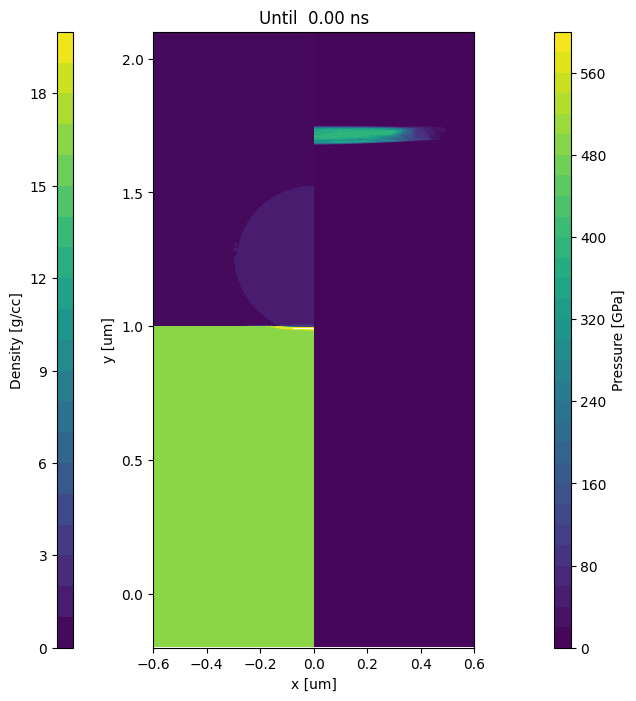

In [6]:
#mpl.use('Cairo') #for png, ps, pdf, svg, ...
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import RegularGridInterpolator
from mpl_toolkits.axes_grid1 import make_axes_locatable
import os

print("\n\n#################################")
print("#### P4P_trace_laser.py ####")
print("#################################\n")



# d_names = ["BIN_laser_900"]
d_names = ["B20"]
# d_names = ["BIN_laser_54","BIN_laser_135","BIN_laser_270"]
# d_names = ["B8","B12","B15","B20","BIN_laser_54","BIN_laser_135","BIN_laser_270","BIN_laser_18","BIN_laser_900"]

for k in range(0,len(d_names),1):
    d_name = d_names[k]

    #テスト/本番設定
    # operation = "test_1"
    operation = "test_2"
    # operation = "actual"
    if operation == "test_1":
      l = 1
      file = 20
      file_path = "./{}/u0000.bin".format(d_name)
    if operation == "test_2":
      l = 20
      file_path = "./{}/u0000.bin".format(d_name)
    if operation == "actual":
      # l = 100
      files = sorted([os.path.join(d_name, f) for f in os.listdir(d_name) if f.endswith('.bin')])
      l = len(files)
      file_path = "./{}/u0000.bin".format(d_name)
    
    print("d_name : ",d_name,"     file_number :",l)
    
    
    data = read_binary_with_structure(file_path)
    
    nx = data['nx']
    ny = data['ny']
    x4 = data['x']
    y4 = data['y']
    u4 = data['u']
    all_z = data['zi']
    mtl = data['mtl']
    rho = data['rho']
    # nxr1 = data['nxr1']
    # nxr2 = data['nxr2']
    # nxr3 = data['nxr3']
    # nxr4 = data['nxr4']
    # nxr5 = data['nxr5']
    # rtthick = data['rtthick']
    # jjfine = data['jjfine']
    # xleft = data['xleft']
    # xright = data['xright']
    # finemesh = data['finemesh']
    # y_out = data['y_out']

    # #パラメータ(cell)
    # nxr1=50
    # nxr2=150
    # nxr3=250
    # nxr4=300
    # nxr5=nx
    # ny=451
    # nx=1251
    # jj2=201
    
    # #パラメータ(cm to m)
    # rtthick = 25e-4*1e-2
    # xleft = 30e-4*1e-2
    # xright = 230e-4*1e-2
    # finemesh = 100e-4*1e-2
    # y_out = 200e-4*1e-2
    #パラメータ(cell)
    nxr1=100
    nxr2=200
    nxr3=700
    nxr4=1250
    nxr5=nx
    ny=451
    nx=1250
    jj2=601
    
    #パラメータ(cm to m)
    rtthick = 1000e-7*1e-2
    xleft = 2000e-7*1e-2
    xright = 1500e-7*1e-2
    finemesh = 600e-7*1e-2
    y_out = 2000e-7*1e-2
    
    #grid(m)
    grid_x = rtthick/(nxr3-nxr2)
    grid_y = finemesh/(jj2-1)
    ts=5.4*1e-9
    
    #grid(m)
    # grid_x = rtthick/(nxr3-nxr2)
    # grid_y = finemesh/(jjfine-1)
    
    #密度と電離度の修正値の抽出
    Target_all = np.where(mtl == 3)
    projectile_all = np.where(mtl == 2)
    ambience_all = np.where(mtl == 1)
    
    target_density = rho[0,0]
    projectile_density = rho[projectile_all[0][0],0]
    print("target_density : {:.2e} [g/cc]".format(target_density))
    print("projectile_density : {:.2e} [g/cc]".format(projectile_density))
    
    ambience_init_ion_deg = np.max(all_z[ambience_all])
    Target_init_ion_deg = np.max(all_z[Target_all])
    projectile_init_ion_deg = np.max(all_z[projectile_all])
    print('ambience_initial_ionization_degree:',ambience_init_ion_deg)
    print('Target_initial_ionization_degree:',Target_init_ion_deg)
    print('projectile_initial_ionization_degree:',projectile_init_ion_deg)
    
    #計算領域の抽出
    # python_xleft = (-rthick -xleft -(nxr2-nxr1)*grid_x)*1e9
    # python_xright = ((nxr4-nxr3)*grid_x +xright)*1e9
    # python_y_out = (finemesh +y_out)*1e9
    # print("xleft:",round(python_xleft,1),"[um],  xright:",round(python_xright,1),"[um], y_max:",round(python_y_out,1),"[um]")
    
    
    ## 抽出したい範囲(cell number)
    x_min = nxr1+1
    x_max = nxr4
    y_max = jj2
    y_min=0
    # y_max = jjfine
    ##描画領域(nm)
    # x_nm_min = -50
    # x_nm_max = 200
    # y_nm_max = 200
    # x_min = round(nxr3-1*solid_ball_radius/grid_x)
    # x_max = round(nxr3+2*solid_ball_radius/grid_x)
    # y_max = round(2*solid_ball_radius/grid_y)
    ## 抽出したい範囲(um)
    x_nm_min = round(((x_min-nxr2)*grid_x)*1e6,1)
    x_nm_max = round(((x_max-nxr2)*grid_x)*1e6,1)
    y_nm_min = 0
    y_nm_max = round((y_max*grid_y)*1e6,1)
    
    x_range = (x_min, x_max)
    y_range = (y_min, y_max)
    
    print("extract_xleft:",x_nm_min,"[um], extract_xright:",x_nm_max,"[um], extract_y_max:",y_nm_max,"[um]")
    print("If the extract region reaches the extended zone, this estimate of the extract resion is not precise.")
    
    max_p =[]
    max_rho =[]
    max_ti =[]
    time = []
    
    print("\n----- start loading -----")
    for i in np.arange(0,l,1):
    
      if operation == "test_1":
        file_path = "./{}/u{:04d}.bin".format(d_name, file)
      if operation == "test_2":
        file_path = "./{}/u{:04d}.bin".format(d_name, i)
      if operation == "actual":
        file_path = "./{}/u{:04d}.bin".format(d_name, i)
    
      print('step:',i,"     file:",file_path,"     time:",data['time'],"[s]")
        
      # データを読み取る(m to nm)
      data = read_binary_with_structure(file_path, x_range, y_range)
      time.append(data["time"])
    
    
      if i == 0:
        x_particles = data["x"].flatten()
        x_particles_0 = data["x"].flatten()
        y_particles = data["y"].flatten()
        y_particles_0 = data["y"].flatten()
        max_p = np.zeros_like(data["P"].flatten())
        max_rho = np.zeros_like(data["rho"].flatten())
    
        # グリッド範囲
        x_grid_1 = np.linspace(data["x"].min(), data["x"].max(), data["P"].shape[0])
        y_grid_1 = np.linspace(data["y"].min(), data["y"].max(), data["P"].shape[1])
    
    
      if i >= 1:
        dt = time[i]-time[i-1]
        # 圧力フィールドの補間関数
        pressure_interp = RegularGridInterpolator((x_grid_1, y_grid_1), data["P"], bounds_error=False, fill_value=None)
        rho_interp = RegularGridInterpolator((x_grid_1, y_grid_1), data["rho"], bounds_error=False, fill_value=None)
        
        # 速度フィールドの補間関数
        u_interp = RegularGridInterpolator((x_grid_1, y_grid_1), data["u"], bounds_error=False, fill_value=0)
        v_interp = RegularGridInterpolator((x_grid_1, y_grid_1), data["v"], bounds_error=False, fill_value=0)
        
        # 現在位置での圧力を取得し、最大圧力を更新
        current_positions = np.array([x_particles, y_particles]).T
        pressures = pressure_interp(current_positions)
        rhos = rho_interp(current_positions)
        max_p = np.maximum(max_p, pressures)
        max_rho = np.maximum(max_rho, rhos)
    
        # 速度に基づいて粒子位置を更新
        u = u_interp(current_positions)
        v = v_interp(current_positions)
        x_particles += u * dt
        y_particles += v * dt
    
           
    # print(data)
    print('-------------------------')
    
    
    fig=plt.figure(figsize=(8,8))
    ax1=fig.add_subplot(111,aspect='equal')
    # Set up a pylab figure
    # set axis labels
    ax1.set_xlabel('x [um]')
    ax1.set_ylabel('y [um]')
    # set axis limits
    ax1.set_ylim([x_nm_min,x_nm_max])
    ax1.set_xlim([-y_nm_max,y_nm_max])
    # ax1.set_xlim([python_xleft,python_xright])
    # ax1.set_ylim([-python_y_out,python_y_out])
    
    # Plot field
    p1=ax1.tricontourf(y_particles_0*1e6,x_particles_0*1e6,max_p*1e-9,levels=np.linspace(0,600,31))
    p2=ax1.tricontourf(-y_particles_0*1e6,x_particles_0*1e6,data["rho"].flatten(),levels=np.linspace(0,20,21))
    
    # add color bar
    # create colorbars to either side of the plot
    divider = make_axes_locatable(ax1)
    cx1=divider.append_axes("right", size="5%", pad=0.8)
    cx2=divider.append_axes("left", size="5%", pad=0.8)
    cb3=fig.colorbar(p1,cax=cx1)
    cb3.set_label('Pressure [GPa]')
    cb4=fig.colorbar(p2,cax=cx2)
    cb4.set_label('Density [g/cc]')
    
    # set labels on left for left side colorbar
    cx2.yaxis.tick_left()
    cx2.yaxis.set_label_position('left')
    
    # set title
    ax1.set_title('Until {: 5.2f} ns'.format(data["time"]*1e9))
    
    if operation == "actual":
      fig.savefig('./Python/P4P_trace/trace_{}.png'.format(d_name))
      # clear axis for next step

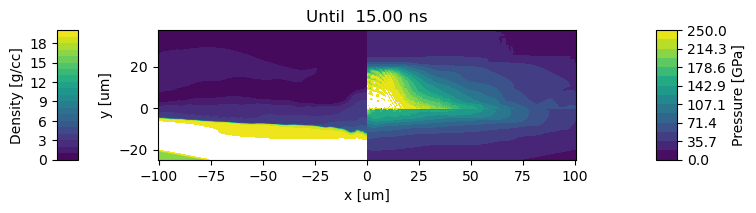

In [138]:
fig=plt.figure(figsize=(8,8))
ax1=fig.add_subplot(111,aspect='equal')
    # Set up a pylab figure
    # set axis labels
ax1.set_xlabel('x [um]')
ax1.set_ylabel('y [um]')
    # set axis limits
ax1.set_ylim([x_nm_min,x_nm_max])
ax1.set_xlim([-y_nm_max,y_nm_max])
    # ax1.set_xlim([python_xleft,python_xright])
    # ax1.set_ylim([-python_y_out,python_y_out])
    
    # Plot field
p1=ax1.tricontourf(y_particles_0*1e6,x_particles_0*1e6,max_p*1e-9,levels=np.linspace(0,5000,15))
p2=ax1.tricontourf(-y_particles_0*1e6,x_particles_0*1e6,data["rho"].flatten(),levels=np.linspace(0,20,21))
    
    # add color bar
    # create colorbars to either side of the plot
divider = make_axes_locatable(ax1)
cx1=divider.append_axes("right", size="5%", pad=0.8)
cx2=divider.append_axes("left", size="5%", pad=0.8)
cb3=fig.colorbar(p1,cax=cx1)
cb3.set_label('Pressure [GPa]')
cb4=fig.colorbar(p2,cax=cx2)
cb4.set_label('Density [g/cc]')
    
    # set labels on left for left side colorbar
cx2.yaxis.tick_left()
cx2.yaxis.set_label_position('left')
   
    # set title
ax1.set_title('Until {: 5.2f} ns'.format(data["time"]*1e9))
    
if operation == "actual":
      fig.savefig('./Python/P4P_trace/trace_{}.png'.format(d_name))
      # clear axis for next step



#################################
#### P4P_images.py ####
#################################

file_number : 1
target_density : 1.67e+01 [g/cc]
projectile_density : 1.67e+01 [g/cc]
ambience_initial_ionization_degree: 0.025740515
Target_initial_ionization_degree: 1.2348504
projectile_initial_ionization_degree: 6.1756487
xleft: -2.2 [um],  xright: 3.4 [um], y_max: 2.6 [um]
extract_xleft: -50 [um], extract_xright: 200 [um], extract_y_max: 200 [um]
If the extract region reaches the extended zone, this estimate of the extract resion is not precise.
extract_xleft: -0.2 [um], extract_xright: 2.1 [um], extract_y_max: -180.6 [um]
If the extract region reaches the extended zone, this estimate of the extract resion is not precise.

----- start loading -----
step: 0      file: ./B20/u0000.bin      time: 0.0 [s]
-------------------------


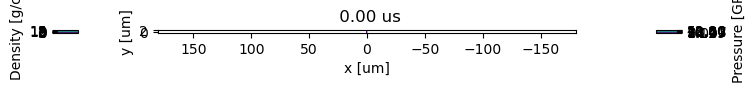

<Figure size 640x480 with 0 Axes>

In [154]:
import matplotlib as mpl
#mpl.use('Cairo') #for png, ps, pdf, svg, ...
import matplotlib.pyplot as plt
import numpy as np
import os
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.optimize import curve_fit
import glob
from scipy.interpolate import griddata
import imageio.v2 as imageio


print("\n\n#################################")
print("#### P4P_images.py ####")
print("#################################\n")


# path= os.getcwd()
# d_name   = os.path.basename(path)
d_name = "B20"
os.makedirs('./Python/P4P_images/P4P_DenPre_{}'.format(d_name), exist_ok=True)
os.makedirs('./Python/P4P_images/P4P_IETmp_{}'.format(d_name), exist_ok=True)
os.makedirs('./Python/P4P_images/P4P_ZiMtl_{}'.format(d_name), exist_ok=True)

#テスト/本番設定
operation = "test_1"
# operation = "test_2"
# operation = "actual"
if operation == "test_1":
  l = 1
  file = 0
  file_path = "./{}/u0000.bin".format(d_name)
if operation == "test_2":
  l = 1
  file_path = "./{}/u0000.bin".format(d_name)
if operation == "actual":
  # l = 100
  files = sorted([os.path.join(d_name, f) for f in os.listdir(d_name) if f.endswith('.bin')])
  l = len(files)
  file_path = "./{}/u0000.bin".format(d_name)

print("file_number :",l)


data = read_binary_with_structure(file_path)
nx = data['nx']
ny = data['ny']
x4 = data['x']
y4 = data['y']
u4 = data['u']
all_z = data['zi']
mtl = data['mtl']
rho = data['rho']
    # nxr1 = data['nxr1']
    # nxr2 = data['nxr2']
    # nxr3 = data['nxr3']
    # nxr4 = data['nxr4']
    # nxr5 = data['nxr5']
    # rtthick = data['rtthick']
    # jjfine = data['jjfine']
    # xleft = data['xleft']
    # xright = data['xright']
    # finemesh = data['finemesh']
    # y_out = data['y_out']

    # #パラメータ(cell)
    # nxr1=50
    # nxr2=150
    # nxr3=250
    # nxr4=300
    # nxr5=nx
    # ny=451
    # nx=1251
    # jj2=201
    
    # #パラメータ(cm to m)
    # rtthick = 25e-4*1e-2
    # xleft = 30e-4*1e-2
    # xright = 230e-4*1e-2
    # finemesh = 100e-4*1e-2
    # y_out = 200e-4*1e-2
    #パラメータ(cell)
nxr1=100
nxr2=200
nxr3=700
nxr4=1250
nxr5=nx
ny=451
nx=1250
jj2=301


#grid(m)
grid_x = rtthick/(nxr3-nxr2)
grid_y = finemesh/(jjfine-1)

#密度と電離度の修正値の抽出
Target_all = np.where(mtl == 3)
projectile_all = np.where(mtl == 2)
ambience_all = np.where(mtl == 1)

target_density = rho[0,0]
projectile_density = rho[projectile_all[0][0],0]
print("target_density : {:.2e} [g/cc]".format(target_density))
print("projectile_density : {:.2e} [g/cc]".format(projectile_density))

ambience_init_ion_deg = np.max(all_z[ambience_all])
Target_init_ion_deg = np.max(all_z[Target_all])
projectile_init_ion_deg = np.max(all_z[projectile_all])
print('ambience_initial_ionization_degree:',ambience_init_ion_deg)
print('Target_initial_ionization_degree:',Target_init_ion_deg)
print('projectile_initial_ionization_degree:',projectile_init_ion_deg)

#計算領域の抽出
python_xleft = np.min(x4)*1e6
python_xright = np.max(x4)*1e6
python_y_out = np.max(y4)*1e6
# python_xleft = (-rthick -xleft -(nxr2-nxr1)*grid_x)*1e9
# python_xright = ((nxr4-nxr3)*grid_x +xright)*1e9
# python_y_out = (finemesh +y_out)*1e9
print("xleft:",round(python_xleft,1),"[um],  xright:",round(python_xright,1),"[um], y_max:",round(python_y_out,1),"[um]")


## 抽出したい範囲(cell number)
x_min = 0
x_max = nx
y_max = ny
##描画領域(nm)
x_nm_min = -50
x_nm_max = 200
y_nm_max = 200
# x_min = round(nxr3-1*solid_ball_radius/grid_x)
# x_max = round(nxr3+2*solid_ball_radius/grid_x)
# y_max = round(2*solid_ball_radius/grid_y)
## 抽出したい範囲(nm)
# x_nm_min = round(((x_min-nxr2)*grid_x-100e-9)*1e9,1)
# x_nm_max = round(((x_max-nxr2)*grid_x-100e-9)*1e9,1)
# y_nm_min = 0
# y_nm_max = round((y_max*grid_y)*1e9,1)

x_range = (x_min, x_max)
y_range = (0, y_max)

print("extract_xleft:",x_nm_min,"[um], extract_xright:",x_nm_max,"[um], extract_y_max:",y_nm_max,"[um]")
print("If the extract region reaches the extended zone, this estimate of the extract resion is not precise.")


    ## 抽出したい範囲(cell number)
x_min = nxr1+1
x_max = nxr4
y_max = jj2
y_min=0
    # y_max = jjfine
    ##描画領域(nm)
    # x_nm_min = -50
    # x_nm_max = 200
    # y_nm_max = 200
    # x_min = round(nxr3-1*solid_ball_radius/grid_x)
    # x_max = round(nxr3+2*solid_ball_radius/grid_x)
    # y_max = round(2*solid_ball_radius/grid_y)
    ## 抽出したい範囲(um)
x_nm_min = round(((x_min-nxr2)*grid_x)*1e6,1)
x_nm_max = round(((x_max-nxr2)*grid_x)*1e6,1)
y_nm_min = 0
y_nm_max = round((y_max*grid_y)*1e6,1)
    
x_range = (x_min, x_max)
y_range = (y_min, y_max)
    
print("extract_xleft:",x_nm_min,"[um], extract_xright:",x_nm_max,"[um], extract_y_max:",y_nm_max,"[um]")
print("If the extract region reaches the extended zone, this estimate of the extract resion is not precise.")




print("\n----- start loading -----")
for i in np.arange(0,l,1):

  if operation == "test_1":
    file_path = "./{}/u{:04d}.bin".format(d_name, file)
  if operation == "test_2":
    file_path = "./{}/u{:04d}.bin".format(d_name, i)
  if operation == "actual":
    file_path = "./{}/u{:04d}.bin".format(d_name, i)

  print('step:',i,"     file:",file_path,"     time:",data['time'],"[s]")
    
  # データを読み取る(m to nm)
  data = read_binary_with_structure(file_path, x_range, y_range)

  all_z = data['zi']
  mtl = data['mtl']
  all_rho = data['rho']
  Target_solid = np.where((mtl == 2)& (all_rho >= target_density))
  Target_mix = np.where((mtl == 2)& (all_rho < target_density) &(all_rho >= projectile_density))
  Target_plasma = np.where((mtl == 2)& (all_rho < projectile_density))
  projectile_solid = np.where((mtl == 3)&(all_rho >= projectile_density))
  projectile_plasma = np.where((mtl == 3)&(all_rho < projectile_density))
  ambience_all = np.where(mtl == 1)

  all_z[Target_solid] = all_z[Target_solid]- Target_init_ion_deg
  all_z[Target_mix] = all_z[Target_mix]- projectile_init_ion_deg
  all_z[Target_plasma] = all_z[Target_plasma]- ambience_init_ion_deg
  all_z[projectile_solid] = all_z[projectile_solid]- projectile_init_ion_deg
  all_z[projectile_plasma] = all_z[projectile_plasma]- ambience_init_ion_deg
  all_z[ambience_all] = all_z[ambience_all]- ambience_init_ion_deg
  
  # print(data)
  print('-------------------------')
  fig=plt.figure(figsize=(8,6))
  ax1=fig.add_subplot(111,aspect='equal')
  # Set up a pylab figure
  # set axis labels
  ax1.set_xlabel('x [um]')
  ax1.set_ylabel('y [um]')
  # set axis limits
  ax1.set_ylim([x_nm_min,x_nm_max])
  ax1.set_xlim([-y_nm_max,y_nm_max])
  # ax1.set_xlim([python_xleft,python_xright])
  # ax1.set_ylim([-python_y_out,python_y_out])

  # Plot field
  p1=ax1.tricontourf(data["y"].flatten()*1e6,data["x"].flatten()*1e6,data["P"].flatten()*1e-9,levels=np.linspace(0,50,15))
  p2=ax1.tricontourf(-data["y"].flatten()*1e6,data["x"].flatten()*1e6,data["rho"].flatten(),levels=np.linspace(0,20,21))

  # add color bar
  # create colorbars to either side of the plot
  divider = make_axes_locatable(ax1)
  cx1=divider.append_axes("right", size="5%", pad=0.8)
  cx2=divider.append_axes("left", size="5%", pad=0.8)
  cb3=fig.colorbar(p1,cax=cx1)
  cb3.set_label('Pressure [GPa]')
  cb4=fig.colorbar(p2,cax=cx2)
  cb4.set_label('Density [g/cc]')

  # set labels on left for left side colorbar
  cx2.yaxis.tick_left()
  cx2.yaxis.set_label_position('left')

    # set title
  ax1.set_title('{: 5.2f} us'.format(data["time"]*1e9))

  plt.show()
  if operation == "actual":
    fig.savefig('./Python/P4P_images/P4P_DenPre_{}/P4P_DenPre_{:05d}.png'.format(d_name,i))
    # clear axis for next step
  plt.clf()

#   fig=plt.figure(figsize=(8,6))
#   ax1=fig.add_subplot(111,aspect='equal')
#   # set axis labels
#   ax1.set_xlabel('x [um]')
#   ax1.set_ylabel('y [um]')
#   # set axis limits
#   ax1.set_ylim([x_nm_min,x_nm_max])
#   ax1.set_xlim([-y_nm_max,y_nm_max])
#   # ax.set_xlim([python_xleft,python_xright])
#   # ax.set_ylim([-python_y_out,python_y_out])

#   # Plot field
#   p5=ax1.tricontourf(data["y"].flatten()*1e6,data["x"].flatten()*1e6,data["ti"].flatten(),levels=np.linspace(0,10,21))
#   p6=ax1.tricontourf(-data["y"].flatten()*1e6,data["x"].flatten()*1e6,data["te"].flatten(),levels=np.linspace(0,10,21))

#   # add color bar
#   # create colorbars to either side of the plot
#   divider = make_axes_locatable(ax1)
#   cx5=divider.append_axes("right", size="5%", pad=0.8)
#   cx6=divider.append_axes("left", size="5%", pad=0.8)
#   cb7=fig.colorbar(p5,cax=cx5)
#   cb7.set_label('Ion energy [eV]')
#   cb8=fig.colorbar(p6,cax=cx6)
#   cb8.set_label('electron energy [eV]')

#   # set labels on left for left side colorbar
#   cx6.yaxis.tick_left()
#   cx6.yaxis.set_label_position('left')
#   # set title
#   ax1.set_title('{: 5.2f} ns'.format(data["time"]*1e9))

#   if operation == "actual":
#     fig.savefig('./Python/P4P_images/P4P_IETmp_{}/P4P_IETmp_{:05d}.png'.format(d_name,i))
#     # clear axis for next step
#   plt.clf()

    
#   fig=plt.figure(figsize=(8,6))
#   ax1=fig.add_subplot(111,aspect='equal')    
#   # set axis labels
#   ax1.set_xlabel('x [um]')
#   ax1.set_ylabel('y [um]')
#   # set axis limits
#   ax1.set_ylim([x_nm_min,x_nm_max])
#   ax1.set_xlim([-y_nm_max,y_nm_max])
#   # ax.set_xlim([python_xleft,python_xright])
#   # ax.set_ylim([-python_y_out,python_y_out])
    
#   p7=ax1.tricontourf(data["y"].flatten()*1e6,data["x"].flatten()*1e6,(data["mtl"]-0.1).flatten(),levels=np.linspace(0,3,4))
#   p8=ax1.tricontourf(-data["y"].flatten()*1e6,data["x"].flatten()*1e6,all_z.flatten(),levels=np.linspace(-1,1,11))

#   # add color bar

#   # create colorbars to either side of the plot
#   divider = make_axes_locatable(ax1)
#   cx9=divider.append_axes("right", size="5%", pad=0.8)
#   cx10=divider.append_axes("left", size="5%", pad=0.8)
#   cb11=fig.colorbar(p7,cax=cx9)
#   cb11.set_label('Material')
#   cb12=fig.colorbar(p8,cax=cx10)
#   cb12.set_label('Ionization degree')
#   # set labels on left for left side colorbar
#   cx10.yaxis.tick_left()
#   cx10.yaxis.set_label_position('left')
#   # set title
#   ax1.set_title('{: 5.2f} ns'.format(data["time"]*1e9))
      
#   # save the figure    
#   if operation == "actual":
#     fig.savefig('./Python/P4P_images/P4P_ZiMtl_{}/P4P_ZiMtl_{:05d}.png'.format(d_name,i))
#     # clear axis for next step
#     plt.clf()

  

# if operation == "actual":
#     # Directory to save images
#     output_dir_1 = './Python/P4P_images/P4P_DenPre_{}/'.format(d_name)
#     output_dir_2 = './Python/P4P_images/P4P_IETmp_{}/'.format(d_name)
#     output_dir_3 = './Python/P4P_images/P4P_ZiMtl_{}/'.format(d_name)
#     output_gif_1 = './Python/P4P_images/P4P_DenPre_{}.gif'.format(d_name)  # Output GIF path
#     output_gif_2 = './Python/P4P_images/P4P_IETmp_{}.gif'.format(d_name)  # Output GIF path
#     output_gif_3 = './Python/P4P_images/P4P_ZiMtl_{}.gif'.format(d_name)  # Output GIF path
#     fps = 60  # 1秒あたりのフレーム数を指定（30FPSなら高速）
#     # FPSからフレーム間隔を計算
#     frame_duration = 1 / fps
    
  
#     image_files_1 = sorted([os.path.join(output_dir_1, f) for f in os.listdir(output_dir_1) if f.endswith('.png')])
#     image_files_2 = sorted([os.path.join(output_dir_2, f) for f in os.listdir(output_dir_2) if f.endswith('.png')])
#     image_files_3 = sorted([os.path.join(output_dir_3, f) for f in os.listdir(output_dir_3) if f.endswith('.png')])
    
#     if len(image_files_1) > 0:
#         print(f"Found {len(image_files_1)} images. Creating/updating GIF...")
#         # Read and write images to GIF
#         images = [imageio.imread(img) for img in image_files_1]
#         imageio.mimsave(output_gif_1, images, duration=frame_duration, loop=0)     
#         print("GIF created/updated successfully:", output_gif_1)
        
#         print(f"Found {len(image_files_2)} images. Creating/updating GIF...")
#         # Read and write images to GIF
#         images = [imageio.imread(img) for img in image_files_2]
#         imageio.mimsave(output_gif_2, images, duration=frame_duration, loop=0)     
#         print("GIF created/updated successfully:", output_gif_2)
        
#         print(f"Found {len(image_files_3)} images. Creating/updating GIF...")
#         # Read and write images to GIF
#         images = [imageio.imread(img) for img in image_files_3]
#         imageio.mimsave(output_gif_3, images, duration=frame_duration, loop=0)     
#         print("GIF created/updated successfully:", output_gif_3)


In [ ]:
data["x"].shape

In [13]:
data["x"].max()*1e6

262.624176684767

In [122]:
max_p.type

AttributeError: 'numpy.ndarray' object has no attribute 'type'

In [59]:

len(x_particles_0)

121220